# **SBI: In-class exercise**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import numpy as np
import emcee
from scipy.stats import poisson
from scipy.stats import chi2
from scipy.optimize import basinhopping
from tqdm import tqdm
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from scipy.stats import norm
from getdist import plots, MCSamples
from scipy.integrate import quad
import multiprocessing
from multiprocessing import Pool

In [2]:
from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation

In [3]:
%matplotlib inline

## Introduction

In the main notebook, our mock observations were generated by simply <span style="color:darkorange">adding some Gaussian noise to the theoretical data</span>. However, in a <span style="color:darkorange">real experiment</span>, our observations may be affected various <span style="color:darkorange">other effects</span>, which may be caused by the instruments, the environment, physical processes, etc. These effects are often very **hard to model with a simple analytical function**, and may introduce additional **biases** in the data.

In this exercise, we will assume that our observations are contaminated by two new effects: random instrumental drift and intermittent calibration errors.

1. **Random instrumental drift**: The instrument that we use to measure the data is not perfect, and its <span style="color:darkorange">calibration may drift over time</span> due to environmental factors or aging hardware. This drift will accumulate over time and so the measurements that we take at different times may be affected by a random offset. We can model this effect by adding a cumulative sum of normally distributed random values to the true magnitudes.
    <details> 
    <summary>Why? <br><br>
    </summary>
    This simulates the effect of a drift that changes the measurements in a continuous but random manner. The random values are drawn from a normal distribution with a mean of zero, ensuring that the drift can go in either direction (positive or negative) and has a variance that reflects the magnitude of the drift per observation.
    <br> <br>
    </details>


2. **Intermittent calibration errors**: The instrument may also suffer from occasional <span style="color:darkorange">large calibration errors</span> that occur at random intervals. This may be caused by a variety of factors, such as power surges, cosmic rays, mechanical disturbances, miscalibrations during the data collection process etc. We model these errors by introducing occasional large spikes in the observed magnitudes.

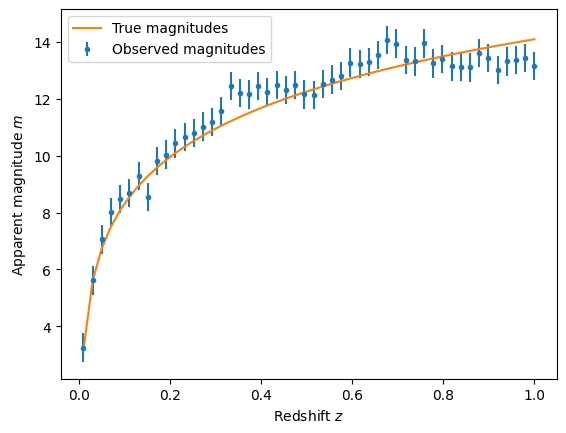

In [4]:
#random seed
np.random.seed(1235)
torch.manual_seed(1234)

# Constants
c = 299792.458  # Speed of light in km/s

# True cosmological parameters
true_Omega_m = 0.3
true_H0 = 70.0  # Hubble constant in km/s/Mpc

# Redshifts of the supernovae
z = np.linspace(0.01, 1.0, 50)

# Noise level in the observed magnitudes
sigma = 0.1

# Luminosity distance function
def luminosity_distance(z, Omega_m, H0):
    """ Calculate the luminosity distance for a given redshift, Omega_m and H0 """
    integrand = lambda z_prime: 1.0 / np.sqrt(Omega_m * (1 + z_prime)**3 + (1 - Omega_m))
    d_L = np.array([quad(integrand, 0, z_i)[0] for z_i in z])
    return (c * (1 + z) * d_L) / H0

# Generate synthetic data
# Generate synthetic data with non-linear transformation
d_L_true = luminosity_distance(z, true_Omega_m, true_H0)
m_true = 5 * np.log10(d_L_true / 10)

# Introduce random walk drift
def random_walk_drift(m, z):
    drift = np.cumsum(np.random.normal(0, 0.2, len(m)))
    return m + drift

# Introduce intermittent calibration errors
def intermittent_calibration_errors(m, z):
    errors = np.zeros_like(m)
    error_indices = np.random.choice(len(m), size=int(len(m) * 0.1), replace=False)
    errors[error_indices] = np.random.normal(0, 1, len(error_indices))
    return m + errors

# Apply both effects to the observed magnitudes
m_obs_drift = random_walk_drift(m_true, z)
m_obs = intermittent_calibration_errors(m_obs_drift, z) + np.random.normal(0, sigma, len(m_true))


# Plot synthetic data
plt.errorbar(z, m_obs, yerr=0.5, fmt='.', label='Observed magnitudes')
plt.plot(z, m_true, label='True magnitudes')
plt.xlabel('Redshift $z$')
plt.ylabel('Apparent magnitude $m$')
plt.legend()
plt.show()


<div class="alert alert-block alert-warning" style="margin-top: 20px">

# Part 1: Solving with Gaussian likelihood

**Problem:** Given the observed magnitudes $m_{\text{obs}}$ and redshifts $z$, infer the cosmological parameters $\Omega_m$ and $H_0$ using the traditional Bayesian approach assuming a Gaussian likelihood.

**Tasks:**
1. Define the prior, a Gaussian likelihood with some $\sigma$ and the posterior.
2. Run MCMC to sample from the posterior.
3. Plot the corner plot of the posterior samples and see if the results are consistent with the true values.

</div>

<div class="alert alert-danger alertdanger" style="margin-top: 20px">

<details>
    <summary><b>Click to see the tip</b></summary>
    
Do ***exactly*** what was done in the main notebook:

- For the prior, use a flat prior over $\Omega_m$ and $H_0$.
- For the Gaussian likelihood, you can assume a $\sigma$ looking at the data (I would assume $\sigma=0.5$, as in the main notebook).
- For MCMC, you can use the `emcee` package.
    
</details>

</div>

Task 1:

In [5]:
# Log-prior function
def log_prior(params):
    Omega_m, H0 = params
    if 0 < Omega_m < 1 and 50 < H0 < 100:
        return 0
    else:
        return -np.inf
    
# Define the log-likelihood function
def log_like(params, z, m_obs):
    Omega_m, H0 = params
    d_L = luminosity_distance(z, Omega_m, H0)
    m_th = 5 * np.log10(d_L / 10)
    sigma_m = 0.5  # Assumed standard deviation of magnitudes
    return -0.5 * np.sum(((m_obs - m_th) / sigma_m)**2)    

# Log-posterior function
def log_post(params, z, m_obs):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + log_like(params, z, m_obs)

Task 2:

In [ ]:
# Sampling with `emcee` 
ndim, nwalkers = 2, 16
ncpus = multiprocessing.cpu_count()

# Initialize walkers around a random position withing the prior volume
pos = np.random.uniform([0, 50], [1, 100], (nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post, args=(z, m_obs))
sampler.run_mcmc(pos, 2000, progress=True)

Task 3:

Removed no burn in


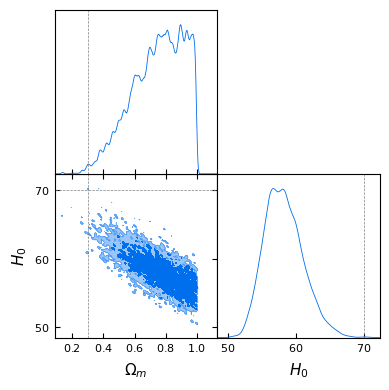

In [7]:
# Get samples and convert to GetDist MCSamples
flat_samples = sampler.get_chain(discard=1000, flat=True)

# GetDist plotting
samples = MCSamples(samples=flat_samples, names=['\Omega_m', 'H_0'], labels=['\Omega_m', 'H_0'])
g = plots.get_subplot_plotter(width_inch=4)
g.triangle_plot(samples, filled=True, markers={'\Omega_m': true_Omega_m, 'H_0': true_H0})
plt.show()

<div class="alert alert-block alert-warning" style="margin-top: 20px">

# Part 2: Solving with Neural Posterior Estimation

**Problem:** Given the observed magnitudes $m_{\text{obs}}$ and redshifts $z$, infer the cosmological parameters $\Omega_m$ and $H_0$ using the Neural Posterior Estimation approach.

**Tasks:**
1. Construct a **simulator** that generates the observed magnitudes $m_{\text{obs}}$ given the cosmological parameters $\Omega_m$ and $H_0$. Encode the random instrumental drifts and intermittent calibration errors in the simulator.
2. Generate a **training dataset** of observed magnitudes $m_{\text{obs}}$ and corresponding cosmological parameters $\Omega_m$ and $H_0$, by running the simulator for a range of randomly drawn parameters $\Omega_m$ and $H_0$. Then, normalize the training data.
3. Define an MPL neural network that will be used as a feature extractor.
4. Define the **Neural Posterior Estimator** class that will use the feature extractor to estimate the posterior with a normalizing flow.
5. Make the training dataset suitable for the NPE, and train the NPE.
6. Sample from the NPE, conditioning on the observed magnitudes $m_{\text{obs}}$ that we had in the beginning.
7. Plot the corner plot of the posterior samples and see if the results are consistent with the true values.

</div>

<div class="alert alert-danger alertdanger" style="margin-top: 20px">

<details>
    <summary><b>Click to see the tip</b></summary>

Again, do ***exactly*** what was done in the main notebook. The actual changes that you need to implement are:
* In the simulator, introduce the random instrumental drifts and intermittent calibration errors.
* For the test data, use instead the observed magnitudes $m_{\text{obs}}$ that we showed in the beginning.

</details>

Task 1:

In [8]:
# Forward model to simulate observed magnitudes
def luminosity_distance_simulator(params, z):
    Omega_m, H0 = params
    d_L = luminosity_distance(z, Omega_m, H0)
    m_th = 5 * np.log10(d_L / 10)
    m_sim_drift = random_walk_drift(m_th, z)
    m_sim = intermittent_calibration_errors(m_sim_drift, z) + np.random.normal(0, sigma, len(m_th))

    return m_sim

Task 2:

In [9]:
np.random.seed(1234) # use random seed for reproducibility

# Generate training data
n_train = 50_000
param_samples = np.random.uniform(low=[0, 50], high=[1, 100], size=(n_train, 2)) # Parameter proposal
x_samples = np.array([luminosity_distance_simulator(theta, z) for theta in tqdm(param_samples)])

# Convert to tensors
param_samples = torch.tensor(param_samples, dtype=torch.float32)
x_samples = torch.tensor(x_samples, dtype=torch.float32)

100%|██████████| 50000/50000 [00:33<00:00, 1502.13it/s]


In [10]:
def normalize(data):
    """ Normalizes the data to have mean 0 and standard deviation 1. """
    mean = data.mean(dim=0)
    std = data.std(dim=0)
    return (data - mean) / std, mean, std

In [11]:
# Normalize the training data
x_norm, x_mean, x_std = normalize(x_samples)
param_norm, param_mean, param_std = normalize(param_samples)

Task 3:

In [12]:
def build_mlp(input_dim, hidden_dim, output_dim, num_layers, activation=nn.GELU()):
    """Builds a multi-layer perceptron (MLP) neural network."""
    layers = [nn.Linear(input_dim, hidden_dim), activation]  # First layer and activation
    
    for _ in range(num_layers):
        layers += [nn.Linear(hidden_dim, hidden_dim), activation] # Hidden layers and activations
        
    layers += [nn.Linear(hidden_dim, output_dim)] # Output layer
    
    return nn.Sequential(*layers)

Task 4:

In [13]:
class NeuralPosteriorEstimator(pl.LightningModule):
    """
    Neural Posterior Estimator using a normalizing flow as the posterior density estimator.

    Parameters:
        featurizer (nn.Module): Neural network for feature extraction.
        d_context (int): Dimension of the context vector.
    """
    
    def __init__(self, featurizer, d_context=16):
        super().__init__()
        self.featurizer = featurizer # Featurizer network for context extraction
        self.flow = self._build_flow(d_in=2, d_hidden=32, d_context=d_context, n_layers=4) # Normalizing flow
    
    def _build_flow(self, d_in, d_hidden, d_context, n_layers):
        """ Instantiate a normalizing flow with Masked Autoregressive Transformations. """
        base_dist = StandardNormal(shape=[d_in]) # base distribution of NF = standard normal 
        transforms = [] # List to hold the series of transformations
        
        for _ in range(n_layers):
            # Reverse permutation to shuffle the features
            transforms.append(ReversePermutation(features=d_in))
            
            # Masked Autoregressive Transform for flexible and expressive transformations
            transforms.append(MaskedAffineAutoregressiveTransform(features=d_in, hidden_features=d_hidden, context_features=d_context))
            
        # Combine all transformations into a composite transform
        transform = CompositeTransform(transforms)
        
        return Flow(transform, base_dist)    

    def forward(self, x):
        return self.featurizer(x) # Extract features using the featurizer
    
    def loss(self, x, params):
        context = self(x)  # Extract context from x using the featurizer
        return -self.flow.log_prob(inputs=params, context=context) # Compute negative log probability

    def training_step(self, batch):
        x, params = batch 
        loss = self.loss(x, params).mean()  # Compute mean loss
        self.log("train_loss", loss) # Log the training loss
        return loss

    def validation_step(self, batch):
        x, params = batch
        loss = self.loss(x, params).mean() # Compute mean validation loss
        self.log("val_loss", loss) # Log the validation loss
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=3e-4) 

In [14]:
featurizer = build_mlp(input_dim=50, hidden_dim=128, output_dim=16, num_layers=4)
npe = NeuralPosteriorEstimator(featurizer=featurizer, d_context=16)

Task 5:

In [15]:
val_fraction = 0.1 # Fraction of data to use for validation
batch_size = 128 
n_samples_val = int(val_fraction * len(x_norm)) 

dataset = TensorDataset(x_norm, param_norm) 
dataset_train, dataset_val = random_split(dataset, [len(x_samples) - n_samples_val, n_samples_val]) 

train_loader = DataLoader(dataset_train, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=False)

In [16]:
trainer = pl.Trainer(max_epochs=20, accelerator='cpu')
trainer.fit(model=npe, train_dataloaders=train_loader, val_dataloaders=val_loader)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/atersenov/miniconda3/envs/astrostat24/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name       | Type       | Params | Mode 
--------------------------------------------------
0 | featurizer | Sequential | 74.6 K | train
1 | flow       | Flow       | 24.3 K | train
--------------------------------------------------
99.0 K    Trainable params
0         Non-trainable params
99.0 K    Total params
0.396     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/atersenov/miniconda3/envs/astrostat24/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


/Users/atersenov/miniconda3/envs/astrostat24/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 19: 100%|██████████| 352/352 [00:06<00:00, 58.06it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 352/352 [00:06<00:00, 57.98it/s, v_num=3]


Task 6:

In [17]:
param_test = np.array([true_Omega_m, true_H0])
x_test = m_obs

x_test_norm = (torch.Tensor(x_test) - x_mean) / x_std # normalize the test data
context = npe.featurizer(x_test_norm).unsqueeze(0)

In [18]:
# Sample from the trained normalizing flow
test_samples = npe.flow.sample(num_samples=10000, context=context) * param_std + param_mean
test_samples = test_samples.detach().numpy().squeeze(0)

Task 7:

Removed no burn in


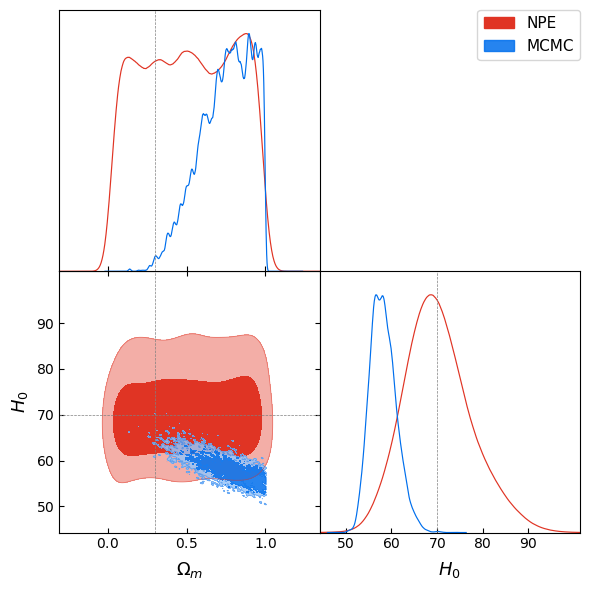

In [21]:
# Create a MCSamples instance
samples_npe = MCSamples(samples=test_samples, labels=['\Omega_m', 'H_0'], names=['\Omega_m', 'H_0'])

true_Omega_m = 0.3
true_H0 = 70

# Create a GetDist plot
g = plots.get_subplot_plotter(width_inch=6)
g.triangle_plot([samples_npe, samples], filled=True, markers={'\Omega_m': true_Omega_m, 'H_0': true_H0}, legend_labels=['NPE', 'MCMC'])
plt.show()